# Pretraining on unlabelled data

## Installation

This notebook uses code from [elcapo/llm-from-scratch](https://github.com/elcapo/llm-from-scratch/). In order to use it:

```bash
git clone https://github.com/elcapo/llm-from-scratch
cd llm-from-scratch

python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt

jupyter notebook
```

**Have fun!**

## Where were we?

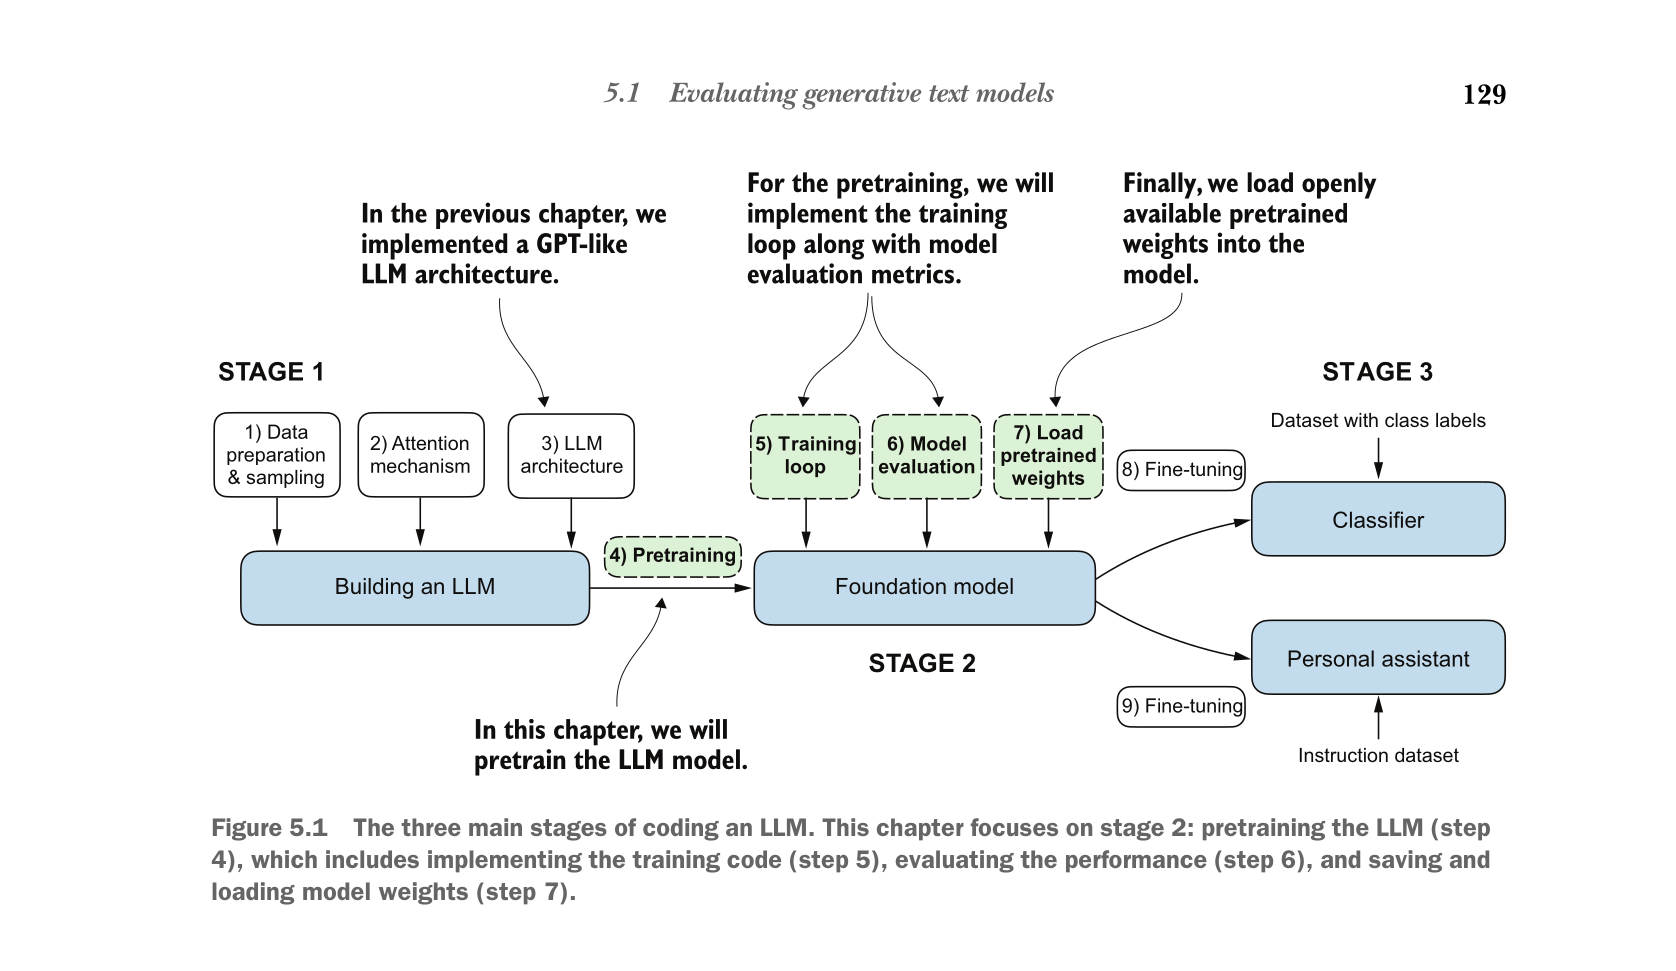

## Where are we going?

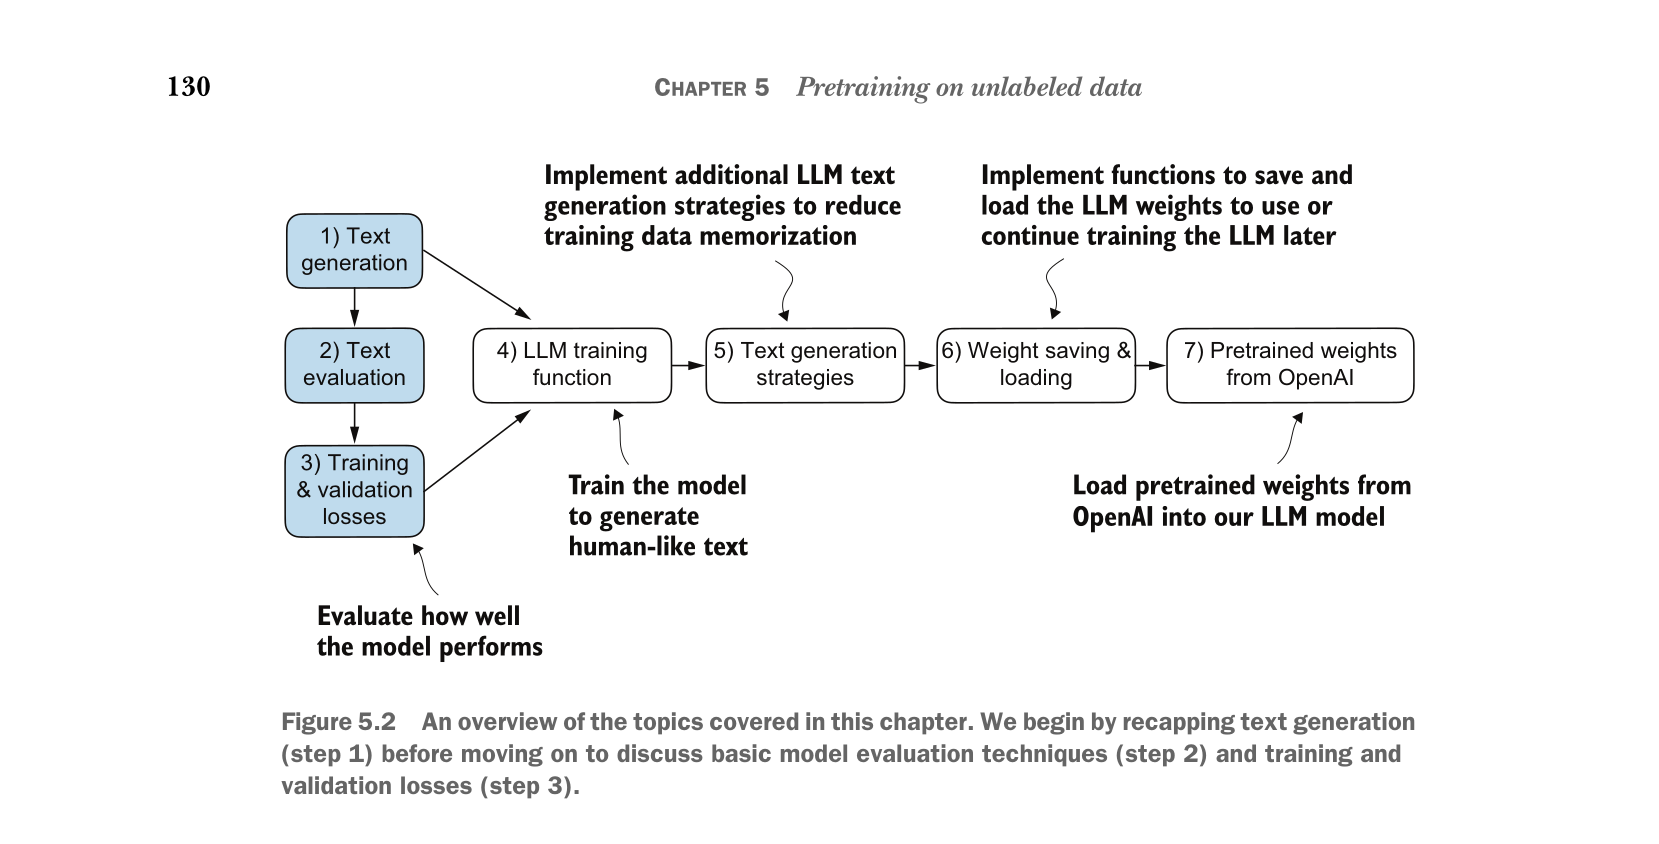

In [1]:
import matplotlib.pyplot as plt
import torch
import warnings

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

In [3]:
from scratch.tokenizers.tiktoken_tokenizer import TiktokenTokenizer

tokenizer = TiktokenTokenizer()

inputs = torch.cat(
    (
        tokenizer.text_to_tokens('every effort moves'),
        tokenizer.text_to_tokens('I really like')
    )
)

targets = torch.cat(
    (
        tokenizer.text_to_tokens(' effort moves you'),
        tokenizer.text_to_tokens(' really like chocolate')
    )
)

### Sources
- [scratch/tokenizers/tiktoken_tokenizer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/tokenizers/tiktoken_tokenizer.py)
- [scratch/tokenizers/base_tokenizer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/tokenizers/base_tokenizer.py)

In [4]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

model = GptModel(config)

### Sources
- [scratch/gpt_config.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_config.py)
- [scratch/gpt_model.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_model.py)

In [5]:
with torch.no_grad():
    logits = model(inputs)

### References

- [torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

In [6]:
# Why are we doing a softmax, here?
probas = torch.softmax(logits, dim=-1)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

### References

- [torch.nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
- [torch.argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html)

In [7]:
# We should obtain the same result without the softmax normalization
token_ids = torch.argmax(logits, dim=-1, keepdim=True)

In [8]:
for batch_id, target in enumerate(targets):
    print("")
    print("Batch:", batch_id + 1)
    print("- Input:", tokenizer.tokens_to_text(inputs[batch_id]))
    print("- Target:", tokenizer.tokens_to_text(target))
    print("- Output:", tokenizer.tokens_to_text(token_ids[batch_id].flatten()))


Batch: 1
- Input: every effort moves
- Target:  effort moves you
- Output:  astounding Gad applic

Batch: 2
- Input: I really like
- Target:  really like chocolate
- Output:  diagonal Swords allows


### References

- [torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [9]:
for batch_id, target in enumerate(targets):
    log_probas = torch.log(probas[batch_id, [0, 1, 2], targets[batch_id]])
    print("")
    print("Batch:", batch_id + 1)
    print("- Logits:", logits[batch_id, [0, 1, 2], targets[batch_id]].tolist())
    print("- Probabilities:", probas[batch_id, [0, 1, 2], targets[batch_id]].tolist())


Batch: 1
- Logits: [-0.21120132505893707, 1.3854831457138062, -0.8993706107139587]
- Probabilities: [1.365970638289582e-05, 6.713520997436717e-05, 6.8525569076882675e-06]

Batch: 2
- Logits: [-0.7834552526473999, -0.3723931610584259, -0.6096072793006897]
- Probabilities: [7.715892934356816e-06, 1.1614359209488612e-05, 9.19272133614868e-06]


In [10]:
def plot_probabilities(batch_id):
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    x = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in targets[batch_id]]
    y = probas[batch_id, [0, 1, 2], targets[batch_id]].tolist()
    
    ax.bar(x, y, color='green')
    ax.set_title('Probabilities before training for batch ' + str(batch_id + 1))
    fig.show()

### References

- [torch.unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)

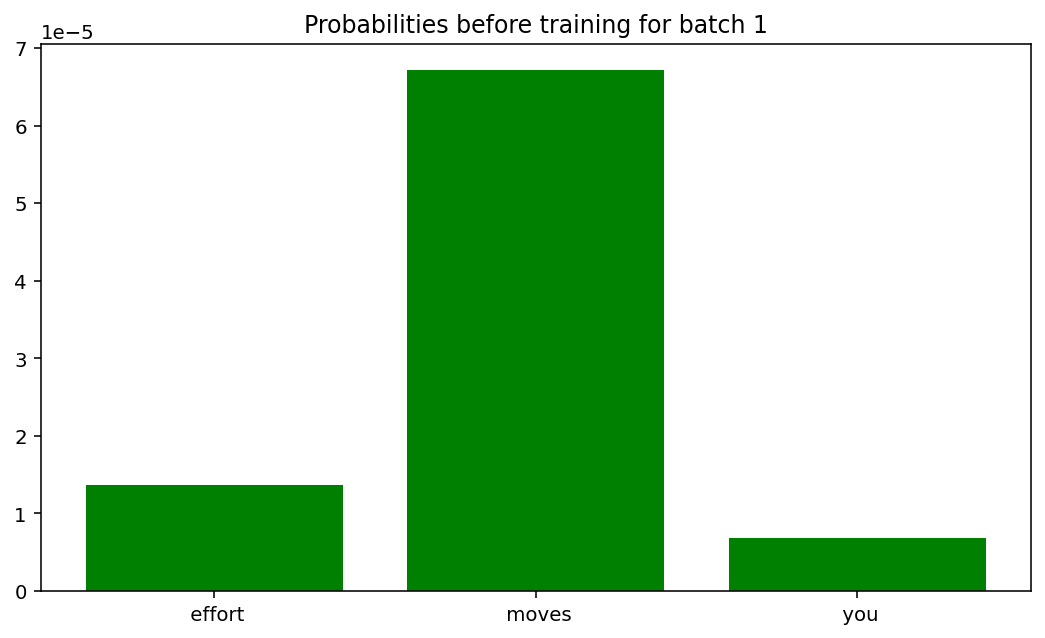

In [11]:
plot_probabilities(batch_id=0)

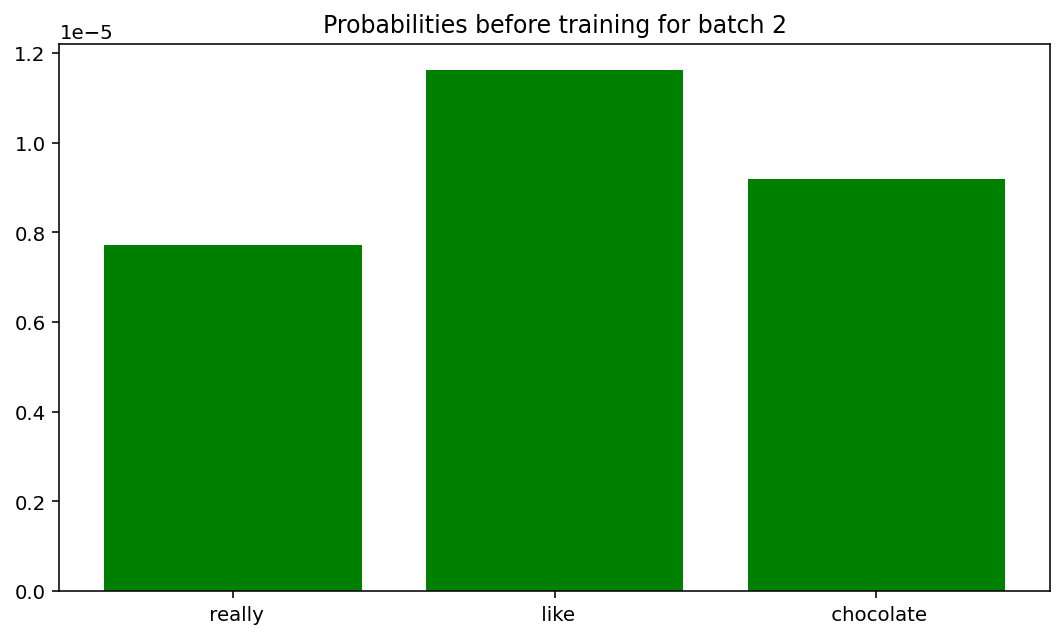

In [12]:
plot_probabilities(batch_id=1)

In [13]:
def plot_contextualized_probabilities(batch_id):
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    batch_words = targets[batch_id]
    other_words = torch.randint(0, config.vocab_size - 1, (6,))

    batch_tokens = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in batch_words]
    other_tokens = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in other_words]
    x = batch_tokens + other_tokens
    
    batch_probas = probas[batch_id, [0, 1, 2], batch_words].tolist()
    other_probas = probas[batch_id, 0, other_words].tolist()
    y = batch_probas + other_probas

    batch_color = ['green' for _ in batch_words]
    other_color = ['red' for _ in other_words]
    c = batch_color + other_color
    
    ax.bar(x, y, color=c)
    ax.set_title('Probabilities before training for batch ' + str(batch_id + 1))
    fig.show()

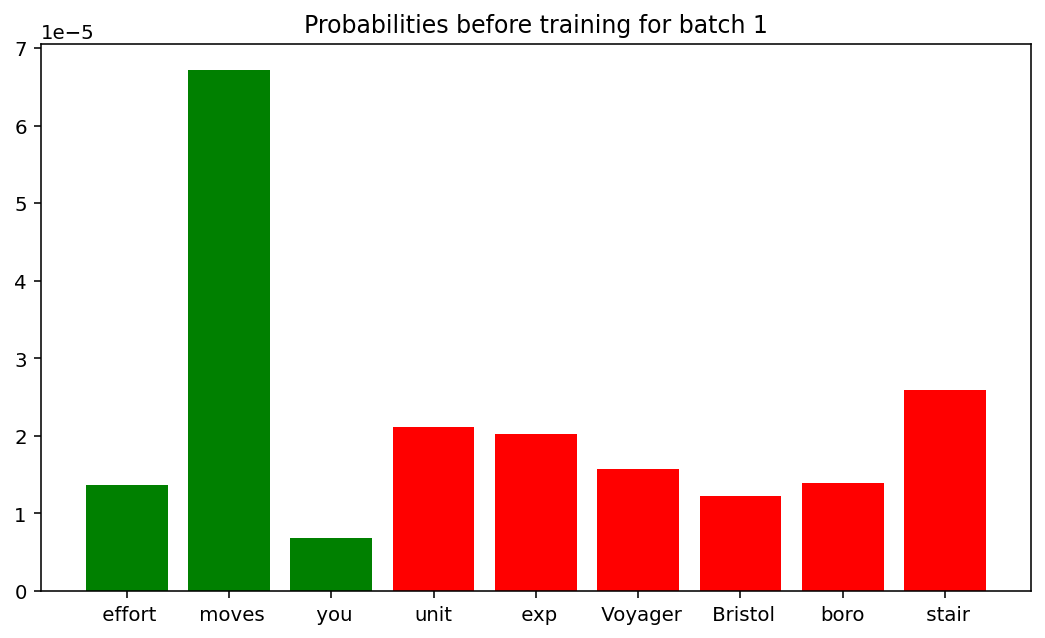

In [33]:
plot_contextualized_probabilities(batch_id=0)

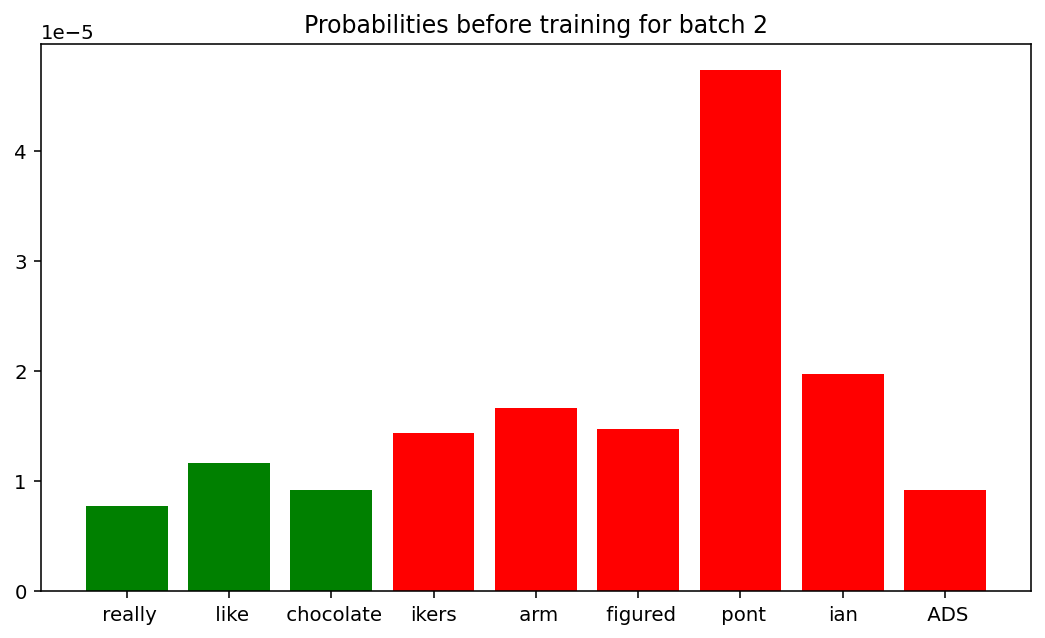

In [34]:
plot_contextualized_probabilities(batch_id=1)

## Text evaluation

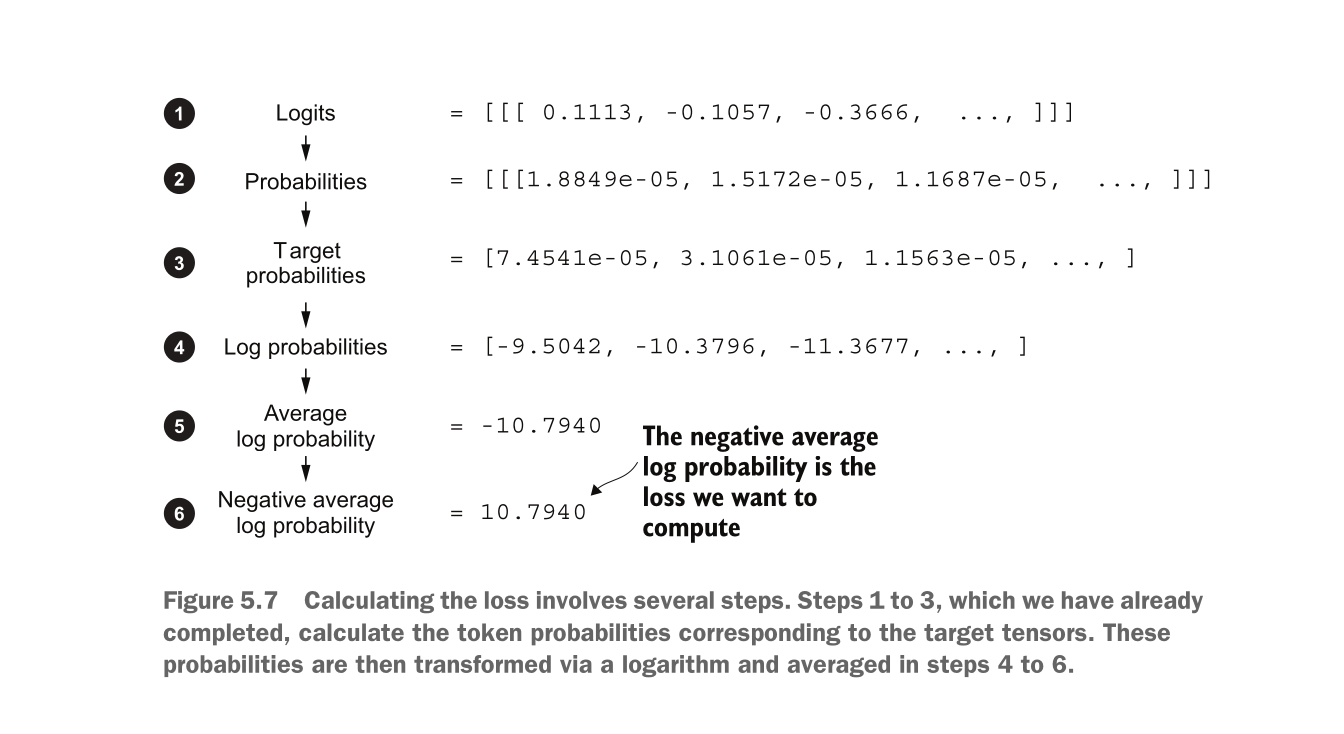

In [16]:
def print_batch_loss(batch_id):
    batch_probas = probas[batch_id, [0, 1, 2], targets[batch_id]]
    log_probas = torch.log(batch_probas)
    print()
    print("Batch:", batch_id + 1)
    print("- Logits:", logits[batch_id, [0, 1, 2], targets[batch_id]].tolist())
    print("- Probabilities:", probas[batch_id, [0, 1, 2], targets[batch_id]].tolist())
    print("- Logarithm of the probabilities:", log_probas)
    print("- Average of the logarithm", torch.mean(log_probas))
    print("- Negative average of the logarithm", -torch.mean(log_probas))

print_batch_loss(batch_id=0)
print_batch_loss(batch_id=1)

print()
print("Overall:")

all_probas = torch.cat(
    (
        probas[0, [0, 1, 2], targets[0]],
        probas[1, [0, 1, 2], targets[1]]
    )
)

all_log_probas = torch.log(all_probas)

print("- Probabilities:", all_probas)
print("- Logarithm of the probabilities:", all_log_probas)
print("- Average of the logarithm", torch.mean(all_log_probas))
print("- Negative average of the logarithm", -torch.mean(all_log_probas))


Batch: 1
- Logits: [-0.21120132505893707, 1.3854831457138062, -0.8993706107139587]
- Probabilities: [1.365970638289582e-05, 6.713520997436717e-05, 6.8525569076882675e-06]
- Logarithm of the probabilities: tensor([-11.2011,  -9.6088, -11.8909])
- Average of the logarithm tensor(-10.9003)
- Negative average of the logarithm tensor(10.9003)

Batch: 2
- Logits: [-0.7834552526473999, -0.3723931610584259, -0.6096072793006897]
- Probabilities: [7.715892934356816e-06, 1.1614359209488612e-05, 9.19272133614868e-06]
- Logarithm of the probabilities: tensor([-11.7722, -11.3633, -11.5971])
- Average of the logarithm tensor(-11.5775)
- Negative average of the logarithm tensor(11.5775)

Overall:
- Probabilities: tensor([1.3660e-05, 6.7135e-05, 6.8526e-06, 7.7159e-06, 1.1614e-05, 9.1927e-06])
- Logarithm of the probabilities: tensor([-11.2011,  -9.6088, -11.8909, -11.7722, -11.3633, -11.5971])
- Average of the logarithm tensor(-11.2389)
- Negative average of the logarithm tensor(11.2389)


### References

- [torch.log](https://pytorch.org/docs/stable/generated/torch.log.html)
- [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)
- [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html)

In [17]:
torch.nn.functional.cross_entropy(logits.flatten(0, 1), targets.flatten())

tensor(11.2389)

### References

- [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

Sounds good but...
- Why are we taking a logarithm?
- Why are we computing an average?
- Why are we switching the sign?

### Logistic regression

Given $h(x)$ as the last activation function, we want a function that separates the "right" values and "wrong" ones, like this:

$$
  P(y|\boldsymbol{x}) = \left\{\def\arraystretch{1.2}%
  \begin{array}{@{}c@{\quad}l@{}}
    h(\boldsymbol{x}) & y = 1 \\
    1 - h(\boldsymbol{x}) & y = 0 \\
  \end{array}\right.
$$

A function that satisfies that, is:

$$
P(y|\boldsymbol{x}) = h(\boldsymbol{x})^y · (1 - h(\boldsymbol{x}))^{1 - y}
$$

For multiple training examples, we want to maximize their overall probability.

As those are independent events, their probabilities multiply:

$$
P(y_1, ..., y_n | \boldsymbol{x}_i, ..., \boldsymbol{x}_n) = \prod_{i=1}^n P(y_i | \boldsymbol{x}_i)
$$

Which is the same as maximizing its logarithm, only that with the logarithm we have to maximise an addition rather than a multiplication.

We added a negative sign because PyTorch comes bundled with functions to minimize gradients.

$$
\mathcal{L} = - \sum_{i=1}^{n} y_i · log(p_i)
$$

Since only the correct tokens contribute to the addition (as $y_i = 0$ for the other ones), the expression can be simplified to:

$$
\mathcal{L} = - log(p_y)
$$

Finally, for a sequence of tokens, the loss is computed as the average or sum of the cross-entropy losses for all predicted tokens in the sequence:

$$
\mathcal{L}_{seq} = \frac{1}{n} \sum_{i=1}^{n} - log(p_{y_i})
$$

#### Sources
- [Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM) by Sebastian Raschka (2021)

## Calculating the training and validation losses

In [18]:
file_path = "tests/fixtures/the-veredict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Total characters 20480
Total tokens 5146


In [19]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
validation_data = text_data[split_idx:]

In [20]:
from scratch.dataloader import create_dataloader

# This only works with batch size 2
# I need an explanation for that!

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0)

### Sources

- [scratch/dataloader.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/dataloader.py)

In [ ]:
print("Train loader")
for x, y in train_loader:
    print("- ", x.shape, y.shape)

print("")
print("Validation loader")
for x, y in validation_loader:
    print("- ", x.shape, y.shape)

In [32]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 0.03534844284877181
Validation loss 7.341490268707275


### Sources

- [scratch/training/loader_loss.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/loader_loss.py)

## Training an LLM

In [39]:
from scratch.training.simple_trainer import SimpleTrainer

# Instantiate the model here to reinitiate its weights every time this cell is executed

model = GptModel(config)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.0004,
    weight_decay = 0.1)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    optimizer,
    tokenizer)

### Sources

- [scratch/training/simple_trainer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/simple_trainer.py)

In [40]:
num_epochs = 10

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 5,
    eval_iter = 5,
    start_context = "Every effort moves you")

Epoch 1
- Step 0
- Train loss 9.755392837524415
- Evaluation loss 9.904759407043457
Epoch 1
- Step 5
- Train loss 7.166804599761963
- Evaluation loss 7.252315044403076
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2
- Step 10
- Train loss 6.293784236907959
- Evaluation loss 6.733535289764404
Epoch 2
- Step 15
- Train loss 6.093603038787842
- Evaluation loss 6.7850213050842285
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Epoch 3
- Step 20
- Train loss 5.93223009109497
- Evaluation loss 6.752729892730713
Every effort moves you, the, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Epoch 4
- Step 25
- Train loss 5.822248554229736
- Evaluation lo

In [30]:
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

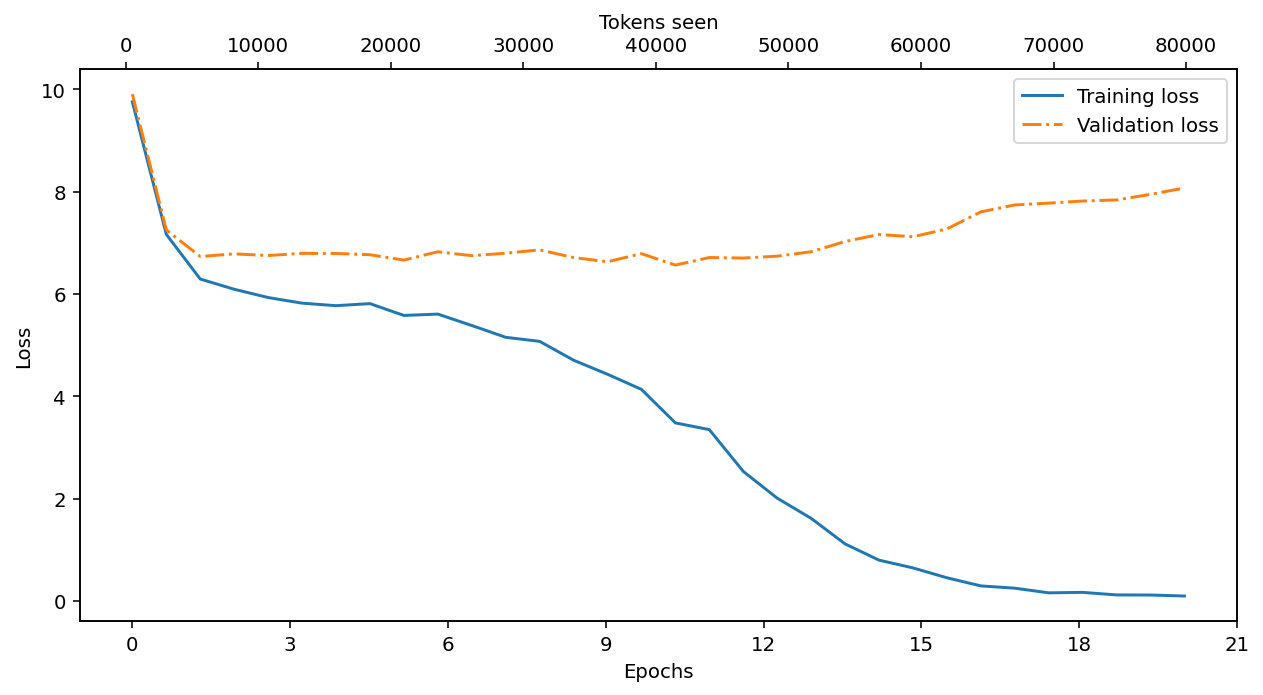

In [48]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)